In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
import numpy as np
import glob
import os

def parse_filename(filename):
    
    # Example filename: "{o_str}_{w_str}_{m_str}_n-steps={n_steps}_attack_results.csv"
    # Strip the directory and extension, handle `_attack_results_part` and then split by '_'
    base_name = os.path.basename(filename)
    base_name = base_name.replace('.csv', '')
    
    parts = base_name.split('_')

    o_str = parts[0]

    if 'GPT' in parts[1]:
        w_str = f"{parts[1]}_{parts[2]}"
        m_str = parts[3]
        domain = parts[4]

    else:
        w_str = parts[1]
        m_str = parts[2]
        domain = parts[3]

    return o_str, w_str, m_str, domain

# Helper function to separate attacks based on step_num reset
def separate_attacks(df):
    attacks = []
    current_attack = []
    
    for idx, row in df.iterrows():
        # Start a new attack if the step_num resets
        if idx > 0 and row['Num'] < df.loc[idx - 1, 'Num']:
            attacks.append(pd.DataFrame(current_attack))
            current_attack = []
        
        current_attack.append(row)
    
    # Append the last attack
    if current_attack:
        attacks.append(pd.DataFrame(current_attack))
    
    return attacks

def summary(df, prefix=""):
    df[f'{prefix}correct'] = (df['Origin'] == df[f'{prefix}choice']).astype(float)
    df[f'{prefix}flipped_correct'] = (df['Origin'] == df[f'{prefix}flipped_choice']).astype(float)
    df[f'{prefix}avg_correct'] = (df[f'{prefix}correct']+df[f'{prefix}flipped_correct'])/2
    print(f"Correct: {df[f'{prefix}correct'].mean()}, Flipped Correct: {df[f'{prefix}flipped_correct'].mean()}, Avg Correct: {df[f'{prefix}avg_correct'].mean()}")

def return_correct_flipped_correct(df, prefix=""):
    df[f'{prefix}correct'] = (df['Origin'] == df[f'{prefix}choice']).astype(float)
    df[f'{prefix}flipped_correct'] = (df['Origin'] == df[f'{prefix}flipped_choice']).astype(float)
    df[f'{prefix}avg_correct'] = (df[f'{prefix}correct']+df[f'{prefix}flipped_correct'])/2
    return df[f'{prefix}correct'].mean(), df[f'{prefix}flipped_correct'].mean(),df[f'{prefix}avg_correct']. mean()

def plot_rolling_avg_correct(df, prefix="", window_size=20):
    # Calculate correctness columns
    df[f'{prefix}correct'] = (df['Origin'] == df[f'{prefix}choice']).astype(float)
    df[f'{prefix}flipped_correct'] = (df['Origin'] == df[f'{prefix}flipped_choice']).astype(float)
    df[f'{prefix}avg_correct'] = (df[f'{prefix}correct'] + df[f'{prefix}flipped_correct']) / 2
    
    # Calculate rolling averages
    df[f'{prefix}rolling_correct'] = df[f'{prefix}correct'].rolling(window=window_size).mean()
    df[f'{prefix}rolling_flipped_correct'] = df[f'{prefix}flipped_correct'].rolling(window=window_size).mean()
    df[f'{prefix}rolling_avg_correct'] = df[f'{prefix}avg_correct'].rolling(window=window_size).mean()
    
    # Plot the rolling averages
    plt.figure(figsize=(12, 6))
    plt.plot(df[f'{prefix}rolling_correct'], label=f'{prefix}Rolling Correct', alpha=0.8)
    plt.plot(df[f'{prefix}rolling_flipped_correct'], label=f'{prefix}Rolling Flipped Correct', alpha=0.8)
    plt.plot(df[f'{prefix}rolling_avg_correct'], label=f'{prefix}Rolling Average Correct', alpha=0.8)
    
    plt.title('Rolling Averages of Correct Decisions')
    plt.xlabel('Index')
    plt.ylabel('Rolling Average')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_rolling_avg_correct_multiple(dfs, prefix="", window_size=20):
    """
    1. For each DataFrame, compute rolling correctness arrays.
    2. Pad the shorter arrays with NaN so all arrays share the same length.
    3. Take the element-wise average (ignoring NaNs).
    4. Plot the final averaged arrays.
    """

    def compute_rolling_arrays(df):
        # Compute correctness columns
        df[f'{prefix}correct'] = (df['Origin'] == df[f'{prefix}choice']).astype(float)
        df[f'{prefix}flipped_correct'] = (df['Origin'] == df[f'{prefix}flipped_choice']).astype(float)
        df[f'{prefix}avg_correct'] = (df[f'{prefix}correct'] + df[f'{prefix}flipped_correct']) / 2
        
        # Compute rolling means (returns a Series)
        rolling_correct = df[f'{prefix}correct'].rolling(window=window_size).mean().values
        rolling_flipped_correct = df[f'{prefix}flipped_correct'].rolling(window=window_size).mean().values
        rolling_avg_correct = df[f'{prefix}avg_correct'].rolling(window=window_size).mean().values
        
        return rolling_correct, rolling_flipped_correct, rolling_avg_correct

    def pad_arrays(array_list):
        # Find max length
        max_len = max(len(arr) for arr in array_list)
        # Create a 2D array filled with NaN
        padded = np.full((len(array_list), max_len), np.nan)
        # Place each array into padded up to its length
        for i, arr in enumerate(array_list):
            padded[i, :len(arr)] = arr
        return padded

    # Lists of rolling arrays for each DataFrame
    rolling_correct_list = []
    rolling_flipped_correct_list = []
    rolling_avg_correct_list = []
    
    # 1. Compute rolling arrays for each DF
    for df in dfs:
        r_correct, r_flipped, r_avg = compute_rolling_arrays(df)
        rolling_correct_list.append(r_correct)
        rolling_flipped_correct_list.append(r_flipped)
        rolling_avg_correct_list.append(r_avg)

    # 2. Pad shorter arrays with NaN
    padded_correct = pad_arrays(rolling_correct_list)
    padded_flipped_correct = pad_arrays(rolling_flipped_correct_list)
    padded_avg_correct = pad_arrays(rolling_avg_correct_list)
    
    # 3. Element-wise average across DataFrames (ignore NaNs)
    combined_rolling_correct = np.nanmean(padded_correct, axis=0)
    combined_rolling_flipped_correct = np.nanmean(padded_flipped_correct, axis=0)
    combined_rolling_avg_correct = np.nanmean(padded_avg_correct, axis=0)
    
    # 4. Plot
    plt.figure(figsize=(12, 6))
    plt.plot(combined_rolling_correct, label=f'{prefix}Combined Rolling Correct', alpha=0.8)
    plt.plot(combined_rolling_flipped_correct, label=f'{prefix}Combined Rolling Flipped Correct', alpha=0.8)
    plt.plot(combined_rolling_avg_correct, label=f'{prefix}Combined Rolling Avg Correct', alpha=0.8)

    plt.title('Combined Rolling Averages of Correct Decisions (Padded by Position)')
    plt.xlabel('Position')
    plt.ylabel('Rolling Average')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_grouped_by_num(df, prefix=""):
    """
    1. Compute correctness columns (correct, flipped_correct, avg_correct).
    2. Group by 'Num' and take the mean for each metric.
    3. Reset the index so that 'Num' is a column (not the index).
    4. Plot the results with 'Num' on the x-axis.
    """
    # 1. Compute correctness columns
    df[f'{prefix}correct'] = (df['Origin'] == df[f'{prefix}choice']).astype(float)
    df[f'{prefix}flipped_correct'] = (df['Origin'] == df[f'{prefix}flipped_choice']).astype(float)
    df[f'{prefix}avg_correct'] = (df[f'{prefix}correct'] + df[f'{prefix}flipped_correct']) / 2

    # 2. Group by 'Num' and compute mean
    grouped = df.groupby('Num')[
        [f'{prefix}correct', f'{prefix}flipped_correct', f'{prefix}avg_correct']
    ].mean()
    
    # 3. Reset index so that 'Num' is a column
    grouped_df = grouped.reset_index()

    # 4. Plot 'Num' on the x-axis
    plt.figure(figsize=(8, 5))
    # plt.plot(grouped_df['Num'], grouped_df[f'{prefix}correct'], marker='o', label='Correct')
    # plt.plot(grouped_df['Num'], grouped_df[f'{prefix}flipped_correct'], marker='o', label='Flipped Correct')
    plt.plot(grouped_df['Num'], grouped_df[f'{prefix}avg_correct'], marker='o', label='Average Correct')
    
    plt.title('Accuracy Grouped by Num')
    plt.xlabel('Num')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:

folder_path = "/data2/borito1907/sandcastles/distinguisher/results"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

sentence_dfs = []
for file in csv_files:
    if "Sentence" not in file:
        continue
    df_temp = pd.read_csv(file)
    sentence_dfs.append(df_temp)

sentence_df = pd.concat(sentence_dfs, ignore_index=True)

span_dfs = []
for file in csv_files:
    if "Span" not in file:
        continue
    df_temp = pd.read_csv(file)
    span_dfs.append(df_temp)

span_df = pd.concat(span_dfs, ignore_index=True)

word_dfs = []
for file in csv_files:
    if "Word" not in file:
        continue
    df_temp = pd.read_csv(file)
    word_dfs.append(df_temp)

word_df = pd.concat(word_dfs, ignore_index=True)

doc1step_dfs = []
for file in csv_files:
    if "Document1Step" not in file:
        continue
    df_temp = pd.read_csv(file)
    doc1step_dfs.append(df_temp)

doc1step_df = pd.concat(doc1step_dfs, ignore_index=True)

dfs = []

for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

combined_df = pd.concat(dfs, ignore_index=True)


In [13]:
data = []

for i, df in enumerate(dfs):
    correct, flipped_correct, avg_correct = return_correct_flipped_correct(df)
    o, w, m, d = parse_filename(csv_files[i])

    if "Document2Step" in m or "DocumentMutator" in m:
        continue

    if d == "space":
        d = "journalism"

    data.append({
        'mutator': m,
        'domain': d,
        'watermarker': w,
        'correct': correct,
        'flipped_correct': flipped_correct,
        'avg_correct': avg_correct
    })

data_df = pd.DataFrame(data)

In [18]:
grouped_df = (
    data_df.groupby('domain')
      .agg({
          'correct': 'mean',
          'flipped_correct': 'mean',
          'avg_correct': 'mean'
      })
      .reset_index()
)

print(grouped_df)

       domain   correct  flipped_correct  avg_correct
0  journalism  0.836137         0.841747     0.838942
1        news  0.881449         0.885288     0.883368
2       paris  0.890710         0.888396     0.889553


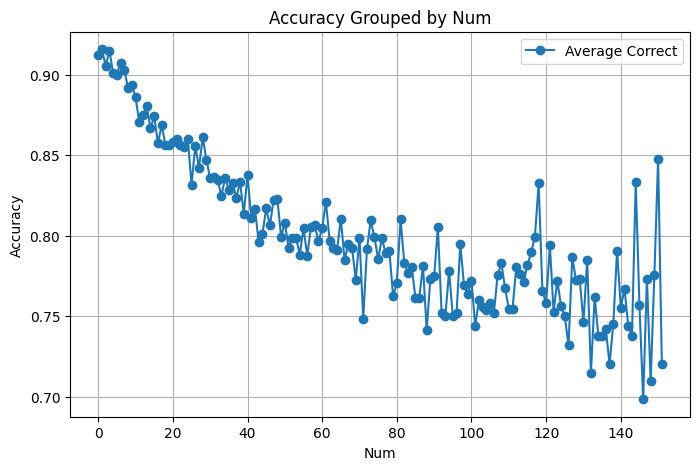

In [7]:
plot_accuracy_grouped_by_num(sentence_df)

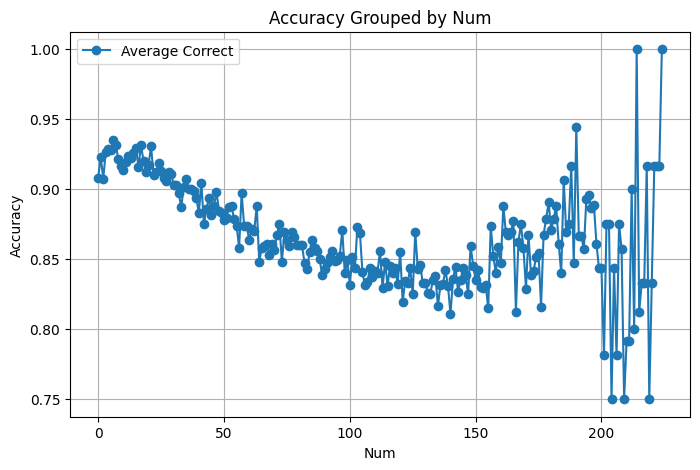

In [8]:
plot_accuracy_grouped_by_num(span_df)

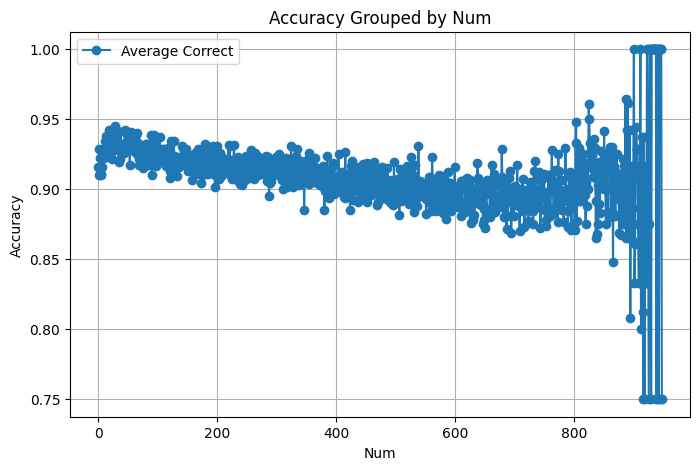

In [9]:
plot_accuracy_grouped_by_num(word_df)

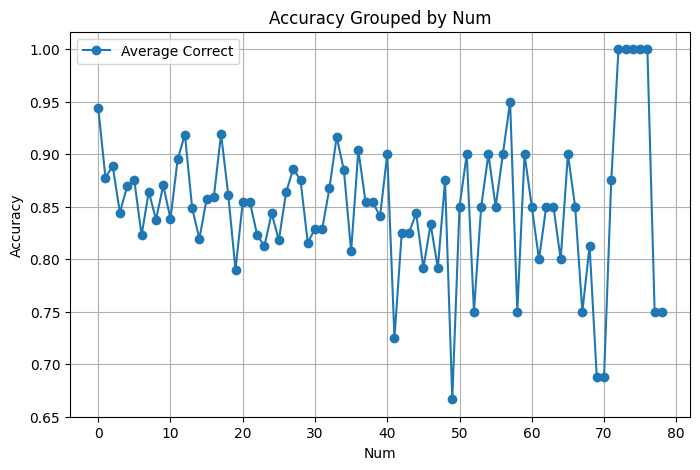

In [10]:
plot_accuracy_grouped_by_num(doc1step_df)

In [11]:
dropdown = widgets.Dropdown(
    options=['avg_correct', 'correct', 'flipped_correct'],
    value='avg_correct',
    description='Statistic:',
)

origin = widgets.Dropdown(
    options=['A', 'B', 'Both'],
    value='Both',
    description='Origin:',
)

slider = widgets.IntSlider(min=1, max=20, step=1, value=1, description='Window:')

def plot(prefix=""):
    match origin.value:
        case 'A':
            data = df[df['Origin'] == 'A'][f'{prefix}{dropdown.value}'].reset_index(drop=True)
            # fall through
        case 'B':
            data = df[df['Origin'] == 'B'][f'{prefix}{dropdown.value}'].reset_index(drop=True)
        case 'Both':
            tmp1 = df[df['Origin'] == 'A'][f'{prefix}{dropdown.value}'].reset_index(drop=True)
            tmp2 = df[df['Origin'] == 'B'][f'{prefix}{dropdown.value}'].reset_index(drop=True)
            data = (tmp1+tmp2)/2
    
    rolling_mean = data.rolling(window=slider.value).mean()
    plt.title(f'{prefix}{dropdown.value} (window={slider.value}, origin={origin.value})')
    plt.xlabel('Mutation number')
    plt.ylabel('Accuracy')
    plt.ylim(-0.1, 1.1)
    plt.yticks([0, 0.5, 1])
    plt.plot(rolling_mean, color='orange')
    plt.show()

widgets.interact(lambda x, y, z: plot(""), x=dropdown, y=slider, z=origin)

interactive(children=(Dropdown(description='Statistic:', options=('avg_correct', 'correct', 'flipped_correct')…

<function __main__.<lambda>(x, y, z)>

FileNotFoundError: [Errno 2] No such file or directory: 'results/stationary_distribution_full.csv'

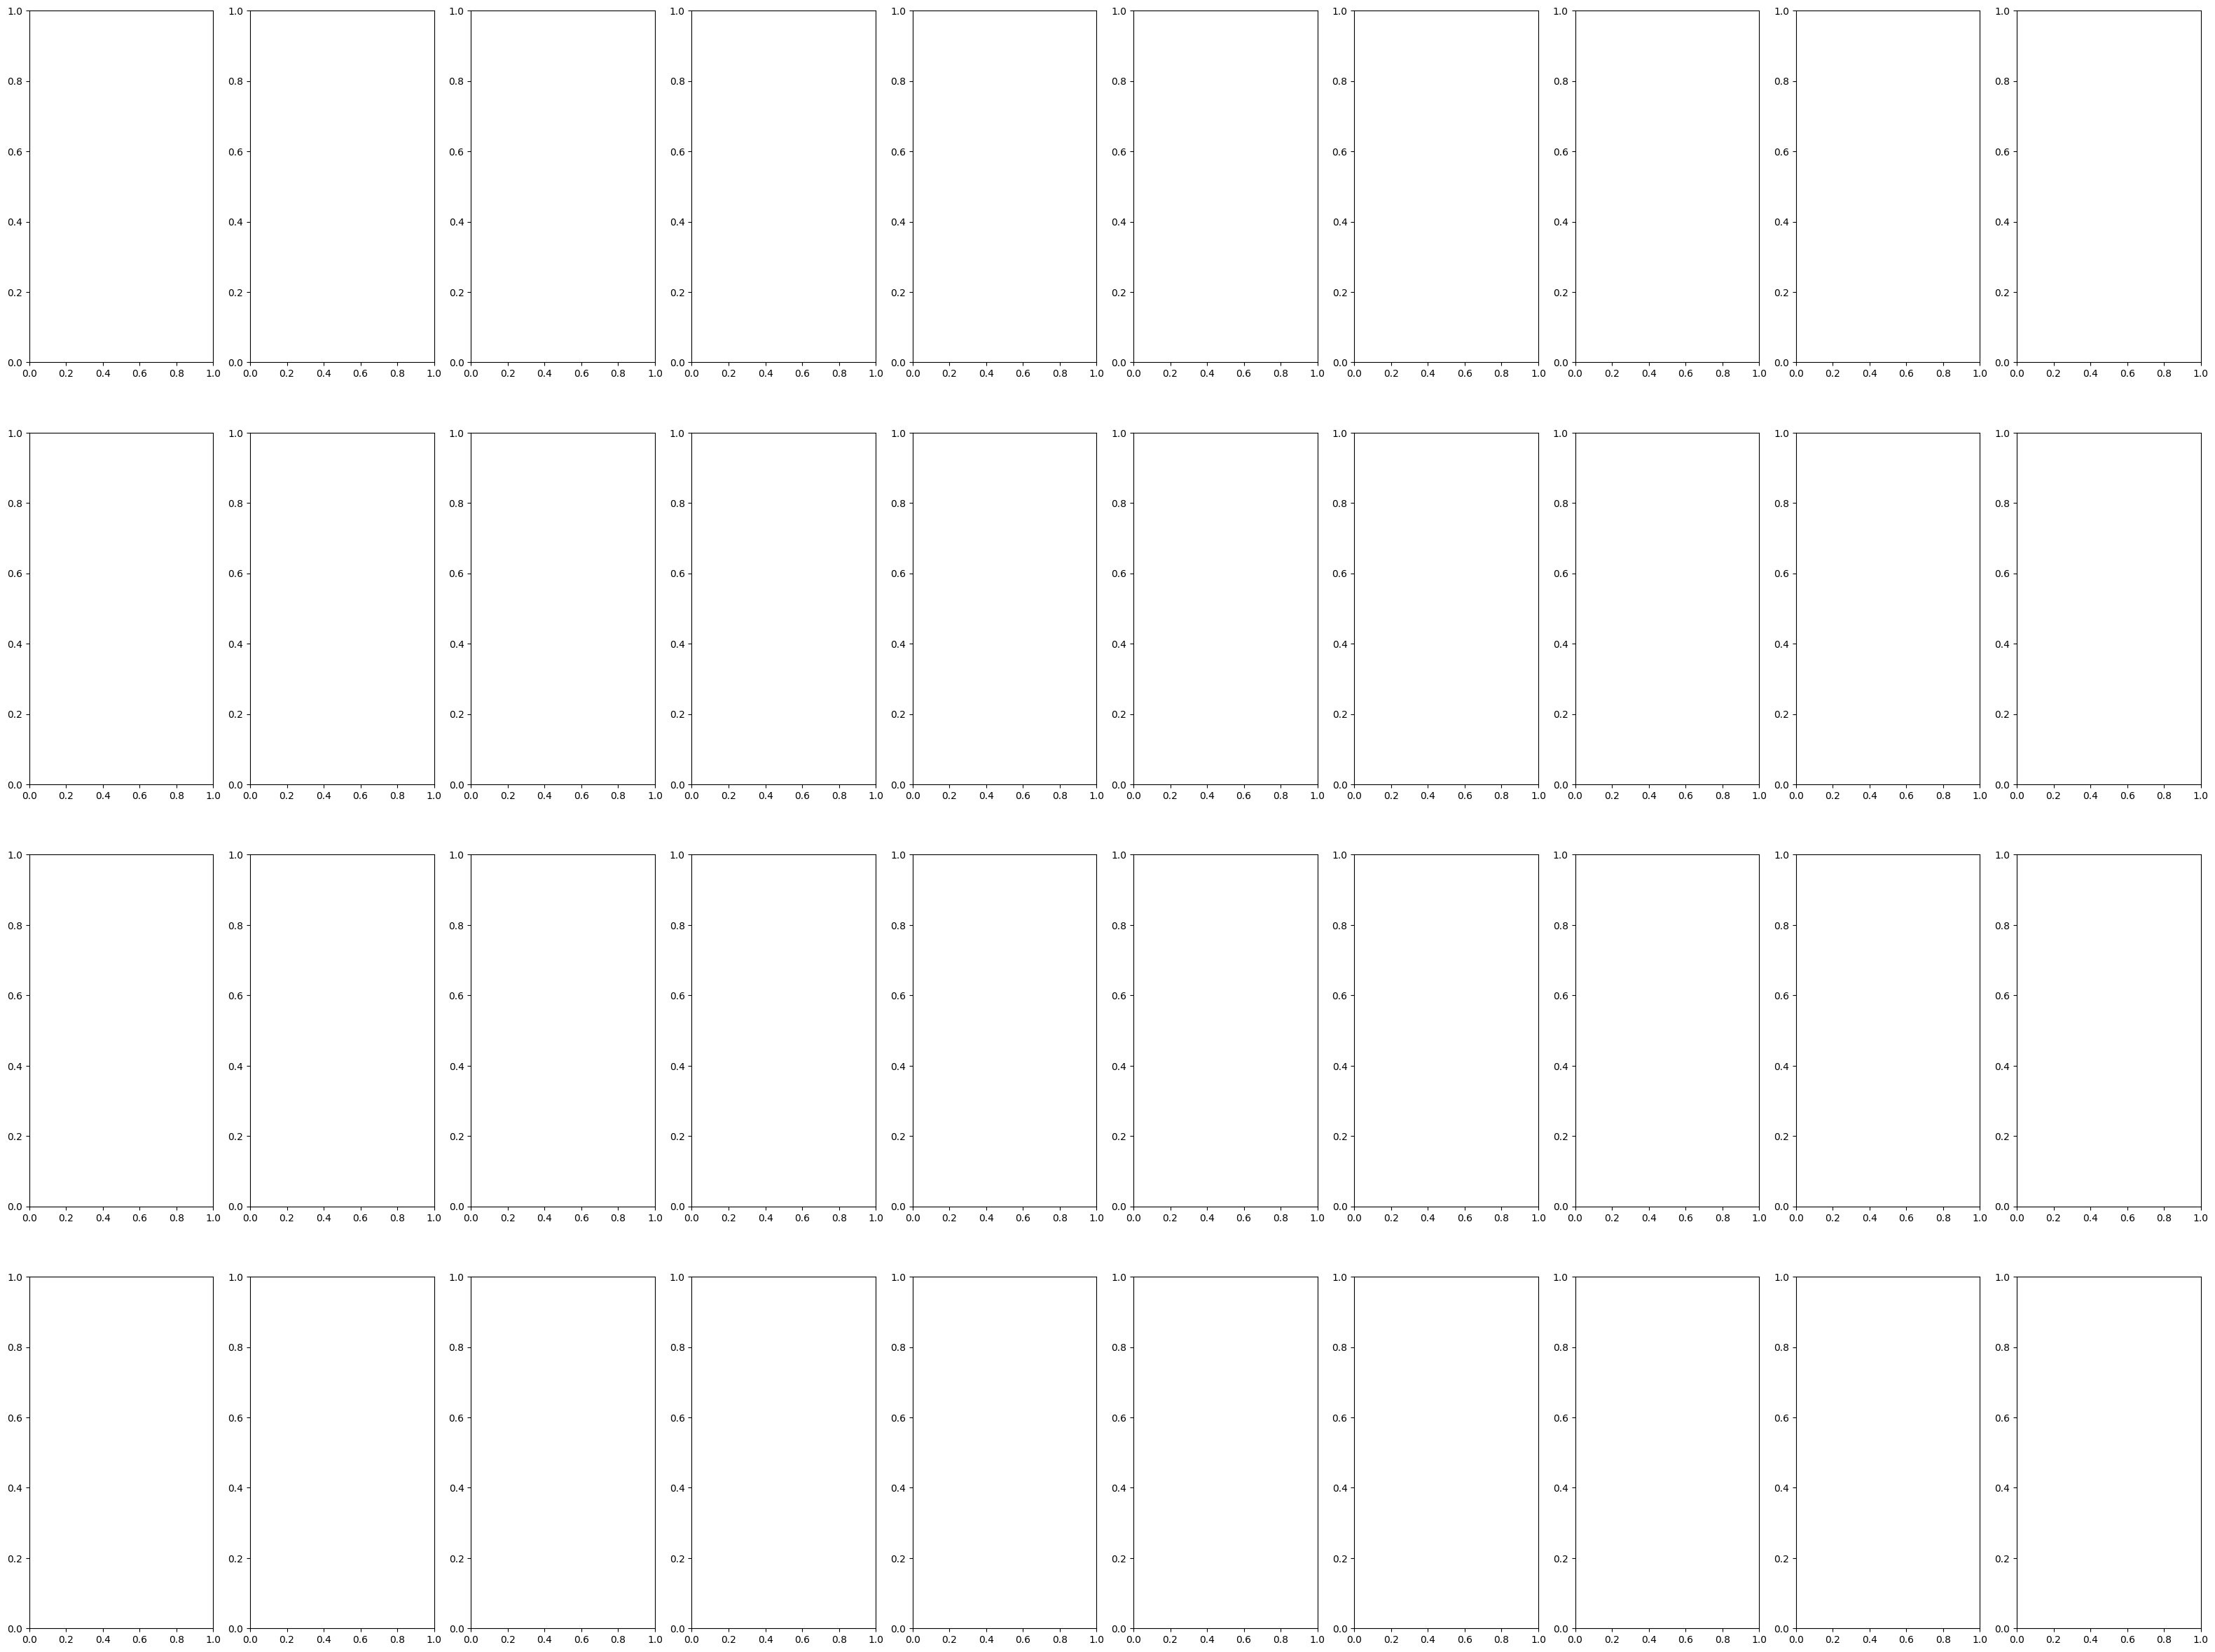

In [12]:
experiments = 8
prompts = 10
trials = experiments * prompts

n_rows = [1,3,4,7]
n_cols = [0,1,2,3,4,5,6,7,8,9]

fig, axes = plt.subplots(len(n_rows), len(n_cols), figsize=(40, 30))

tdf = pd.read_csv(f'results/stationary_distribution_full.csv')

def summary(df, prefix=""):
    df[f'{prefix}correct'] = (df['Origin'] == df[f'{prefix}choice']).astype(float)
    df[f'{prefix}flipped_correct'] = (df['Origin'] == df[f'{prefix}flipped_choice']).astype(float)
    df[f'{prefix}avg_correct'] = (df[f'{prefix}correct']+df[f'{prefix}flipped_correct'])/2
    print(f"Correct: {df[f'{prefix}correct'].mean()}, Flipped Correct: {df[f'{prefix}flipped_correct'].mean()}, Avg Correct: {df[f'{prefix}avg_correct'].mean()}")

for i in range(trials):
    t_row = i // prompts
    t_col = i % prompts
    if t_row not in n_rows or t_col not in n_cols:
        continue
    row = n_rows.index(t_row)
    col = n_cols.index(t_col)
    df = tdf[tdf['id'] == i].copy(deep=True)
    print(i)
    summary(df)
    tmp1 = df[df['Origin'] == 'A']['avg_correct'].reset_index(drop=True)
    tmp2 = df[df['Origin'] == 'B']['avg_correct'].reset_index(drop=True)
    data = (tmp1+tmp2)/2
    window = 10
    rolling_mean = data.rolling(window=window).mean()[window-1:].reset_index()
    axes[row, col].plot(rolling_mean, color='orange')
    if row == 0:
        axes[row, col].set_title(f'difficulty={df.iloc[0]["entropy"]}', fontsize=20, pad=20)
    if col == 0:
        axes[row, col].set_ylabel(f'{df.iloc[0]["m_str"]}, origin={df.iloc[0]["compare_against_original"]}', fontsize=20, labelpad=40)
    axes[row, col].axhline(y=0.5, color='red', linestyle='--')
    axes[row,col].set_ylim(-0.1, 1.1)
    axes[row,col].set_xlim(0, None)

plt.tight_layout()
plt.show()
